
# MODEL B


## CM3070 Computer Science Final Project

### Deep Learning on a public dataset project template (Machine Learning and Neural Networks)
### CIFAR 10 Dataset






## 1. Importing the CIFAR-10 Dataset

In this project, we are going to use the CIFAR-10 dataset to train an **image classification**, Convolutional Neural Networks (CNN), Machine Learning model.

Hence, as a first step, we need to import the dataset to be used in this notebook. To facilitate the process, we are going to use TensorFlow Datasets library. The library provides useful tools, as built in functions that splits the dataset to be used by the model.



In [ ]:
# Reduce log output for tensorflow
import os
# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Import tensorflow and numpy
import tensorflow_datasets as tfds
import tensorflow as tf
import numpy as np

# import the CIFAR-10 datasets objects from tfds for general evaluation
ds, ds_info = tfds.load('cifar10', with_info=True)

# class names
names = ds_info.features['label'].names
print("CIFAR-10 dataset general information")
print("---------------------------------------------------")
print("Number of images:       ", ds_info.splits['all'].num_examples)
print("Image size in pixels    ", ds_info.features["image"].shape[0], " x ", ds_info.features["image"].shape[1])
print("Number of classes:      ", ds_info.features['label'].num_classes)
print("Classes in the dataset: ", names)

CIFAR-10 dataset general information
---------------------------------------------------
Number of images:        60000
Image size in pixels     32  x  32
Number of classes:       10
Classes in the dataset:  ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']



### 1.1 Dataset Samples

As seen above, the CIFAR-10 dataset comprises 60000 images in 10 different classes. Below is a sample of the first 10 images in the dataset:

Image samples for each class in CIFAR-10 dataset:
---------------------------------------------------


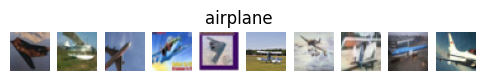

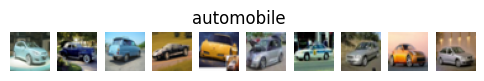

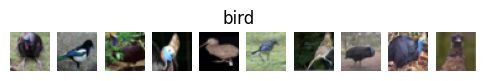

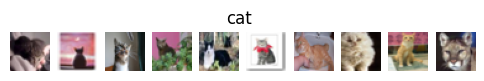

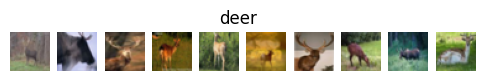

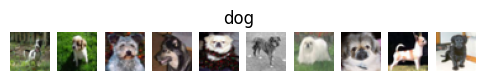

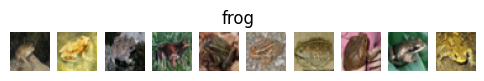

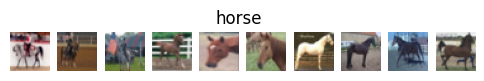

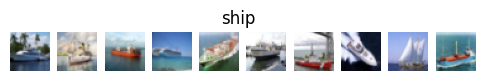

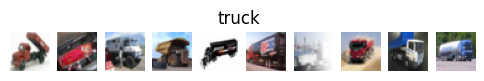

In [ ]:
import matplotlib.pyplot as plt

def plot_images_for_classname(classname):
  '''
  Plot a row with 10 images corresopnding to the input classname
  :param classname: A string representing a class in the CIFAR-10 dataset
  '''
  i = 0
  fig, ax = plt.subplots(1, 10, figsize=(6,6))
  for sample in ds['train']:
    if names[sample['label']] == classname:
      # disable plot axis
      ax[i].axis('off')
      # set image label
      # ax[i].set_title(names[sample['label']])
      # show image
      ax[i].imshow(sample['image'])
      i += 1

      # break loop when 10 images for the class are plotted
      if i == 10:
        break
  # set title
  plt.title(classname,x=-5)

  # show images
  plt.show()

print("Image samples for each class in CIFAR-10 dataset:")
print("---------------------------------------------------")

# iterate over all class in CIFAR-10 and print a row with 10 image samples
for name in names:
  plot_images_for_classname(name)

## 2. Preparing the CIFAR-10 dataset

In this step of the notebook we are going to prepare the CIFAR-10 dataset before feeding it into the model. This process will involve:
- Splitting the full dataset into train (40000 samples), validation (10000 samples) e test (10000 samples) sets.
- Normalising pixel values from integers to floats (from 0-255 to 0-1 values);
- One-hot encoding class values;


### 2.1 Splitting the data into training/validation/test sets

As explained, the CIFAR-10 dataset will be divided into training, validation and test sets, following a 40000/10000/10000 split, respectively.

We will also shuffle the dataset and define a seed value so as to make results repeatable. We will achieve that by using 'shuffle_files=True' and passing a configuration object with 'shuffle_seed' value into 'read_config' parameter in tfds.load() function.

CIFAR-10 split (samples per set):
-----------------------------------------
Train set length:       40000
Test set length:        10000
Validation set length:  10000




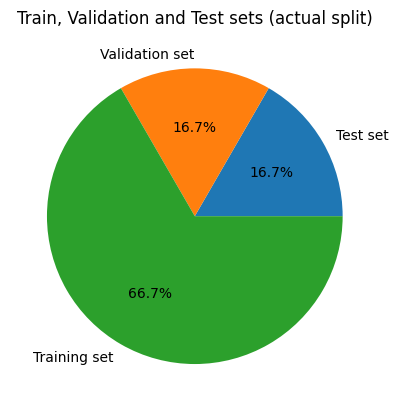

In [ ]:
import time

# define the amount of samples in each subset of the full dataset
split = ['train[:40000]', "train[40000:50000]" ,'test']

# set shuffle_seed value
config = tfds.ReadConfig()
config.shuffle_seed = 10

# retrieve the cifar10 dataset, shuffle and split it
train_set, validation_set, test_set = tfds.load('cifar10',split=split, shuffle_files=True, read_config=config, as_supervised=True)

# print bins sizes
print("CIFAR-10 split (samples per set):")
print("-----------------------------------------")
print("Train set length:      ", len(train_set))
print("Test set length:       ", len(test_set))
print("Validation set length: ", len(validation_set))
print("\n")

# plot proportions in pie chart
labels = 'Test set', 'Validation set', 'Training set'
sizes = [len(test_set), len(validation_set), len(train_set)]
plt.pie(sizes, labels=labels, autopct='%1.1f%%')
plt.title("Train, Validation and Test sets (actual split)")
plt.show()

### 2.2 Normalizing pixel values

The images in the CIFAR-10 dataset are uniform and small, with only 32x32 pixels in dimension. Therefore, there's no need to tweak image sizes, but we need to normalise pixel values, from integers in the 0-255 range, to floats values in the 0-1 range. This will be achieved by simply dividing the each image Tensor by 255.

Normalisation of pixel values is not only common in image classification models (as seen in the Previous Work section of the report), but also recommended by Chollet in this book "Deep Learning with Python¨, page 101. Large integer values in tensors can make it difficult for the model to converge when updating gradients.


In [ ]:
def normalize(image, label):
  '''
  Given an image and a label, normalizes pixel values
  Returns both.
  Inspiration drawn from https://lindevs.com/classify-images-of-dogs-and-cats-using-cnn-and-tensorflow-2
  '''
  return image / 255, label

before_normalize = list(next(iter(train_set))[0][0])[0]

# Normalise datasets
train_set = train_set.map(normalize)
validation_set = validation_set.map(normalize)
test_set = test_set.map(normalize)

after_normalize = list(next(iter(train_set))[0][0][0])

print("First pixel of the first image (train set) before normalize:")
print(list(np.array(before_normalize)))
print("----------------------------------------")
print("First pixel of the first image (train set) after normalize:")
print(list(np.array(after_normalize)))

First pixel of the first image (train set) before normalize:
[143, 96, 70]
----------------------------------------
First pixel of the first image (train set) after normalize:
[0.56078434, 0.3764706, 0.27450982]


### 2.3 One-hot encoding labels

When working with image classification tasks, we also need to one-hot encode class labels. We will achieve this task with the help of Tensorflow built in function "one_hot()":

In [ ]:
def one_hot_encoding(image, label):
  '''
  Given an image/label pair, one-hot encodes the label value into and array of integers 0 and 1.
  Returns the image and a one-hot tensor
  '''
  class_depth = 10 # number of classes in the dataset
  return image, tf.one_hot(label, class_depth)

before_one_hot = next(iter(train_set))[1] # first element label

# one-hot encoding for all subsets
# We also need to return batches of 32 images. This is required by Keras, otherwise
# we won't be able to feed the datasets into its layers.
train_set = train_set.map(one_hot_encoding).batch(32)
validation_set = validation_set.map(one_hot_encoding).batch(32)
test_set = test_set.map(one_hot_encoding).batch(32)

after_one_hot = next(iter(train_set))[1][0] # first element label

print("First image label (train set) before one-hot encoding: ", int(before_one_hot))
print("First image label (train set) after one-hot encoding:  ", list(np.array(after_one_hot)))

First image label (train set) before one-hot encoding:  7
First image label (train set) after one-hot encoding:   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0]


## 3 Defining MODEL_B
In this model, we will try to fix the overfitting of MODEL_A by adding a few Dropout layers, while keeping all other layers intact. Fixing overfitting will allow us to keep scaling up the model in pursue of better accuracy.

In [ ]:
# setup layers
model = tf.keras.models.Sequential()

# Conv2D/MaxPooling/Dropout layers
model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(4,4), activation='relu', input_shape=(32,32,3)))
model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2)))
model.add(tf.keras.layers.Dropout(0.3))

model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=(4,4), activation='relu'))
model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2)))
model.add(tf.keras.layers.Dropout(0.3))

model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dropout(0.3))
# Dense layer that outputs probabilities for all classes
model.add(tf.keras.layers.Dense(10, activation='softmax'))

# compile the model
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# print the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 29, 29, 32)        1568      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 14, 14, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        32832     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 5, 5, 64)          0

Having created the model, we can now go further and train it against train and validation sets:

In [ ]:
# Train the model with train and validation sets
history = model.fit(train_set, validation_data=validation_set, epochs=8) # 8 epochs

Epoch 1/8
1250/1250 [==============================] - 10s 5ms/step - loss: 1.6456 - accuracy: 0.4039 - val_loss: 1.3219 - val_accuracy: 0.5290
Epoch 2/8
1250/1250 [==============================] - 5s 4ms/step - loss: 1.3415 - accuracy: 0.5246 - val_loss: 1.1738 - val_accuracy: 0.5884
Epoch 3/8
1250/1250 [==============================] - 5s 4ms/step - loss: 1.2220 - accuracy: 0.5726 - val_loss: 1.0918 - val_accuracy: 0.6289
Epoch 4/8
1250/1250 [==============================] - 5s 4ms/step - loss: 1.1605 - accuracy: 0.5972 - val_loss: 1.1226 - val_accuracy: 0.6229
Epoch 5/8
1250/1250 [==============================] - 5s 4ms/step - loss: 1.1142 - accuracy: 0.6164 - val_loss: 1.0411 - val_accuracy: 0.6457
Epoch 6/8
1250/1250 [==============================] - 5s 4ms/step - loss: 1.0999 - accuracy: 0.6258 - val_loss: 1.0233 - val_accuracy: 0.6570
Epoch 7/8
1250/1250 [==============================] - 5s 4ms/step - loss: 1.0790 - accuracy: 0.6336 - val_loss: 1.1306 - val_accuracy: 0.626

To better visualize results, let's plot graphs for the training history:

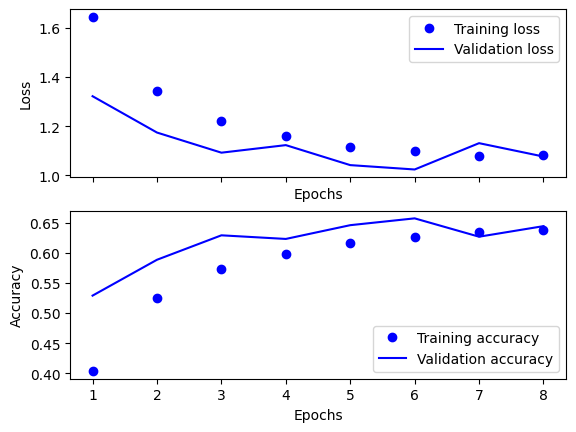

In [ ]:
# Plotting the loss for the model
# Code inspired by Chollet's DLWP, page 74
def plot_history(history_dict,num_epochs):
  '''
  Plots Accuracy and Loss curves over epochs given a history dictionary
  '''
  fig, ax = plt.subplots(2, sharex=True)

  # grab values
  loss_values = history_dict['loss']
  val_loss_values = history_dict['val_loss']
  acc_values = history_dict['accuracy']
  val_acc_values = history_dict['val_accuracy']
  epochs = range(1, num_epochs + 1) # 1 to n epochs, as ran in the model

  # define loss curve
  ax[0].plot(epochs, loss_values, 'bo', label='Training loss')
  ax[0].plot(epochs, val_loss_values, 'b', label='Validation loss')
  ax[0].set(xlabel="Epochs", ylabel="Loss")
  ax[0].legend()

  # define accuracy curve
  ax[1].plot(epochs, acc_values, 'bo', label='Training accuracy')
  ax[1].plot(epochs, val_acc_values, 'b', label='Validation accuracy')
  ax[1].set(xlabel="Epochs", ylabel="Accuracy")
  ax[1].legend()
  plt.show()

history_dict = history.history # history object with training metrics
plot_history(history_dict,8)

#### 3.1 MODEL B evaluation

MODEL_B has improved on MODEL_A by simply adding Dropout layers between after each Conv2D/MaxPool layer block, and after the Densely connected 'relu' activation layer. Even though MODEL_B has not improved in terms of accuracy, adding Dropout has clearly improved the overfitting from MODEL_A. Hence, I understand that, from now on, we can keep scaling up the model in search of better performance.

In [ ]:
# evaluate model against test_set
result = model.evaluate(test_set)
print("\nLoss: " + str(result[0]))
print("Accuracy: " + str(result[1]))

313/313 [==============================] - 1s 2ms/step - loss: 1.0810 - accuracy: 0.6437

Loss: 1.080994963645935
Accuracy: 0.6437000036239624


As seen, accuracy results against the test_set stayed the same. But the model is not overfitting anymore. From now on we can keep scaling up.


313/313 [==============================] - 1s 2ms/step

Actual image label vs Predicted image label 



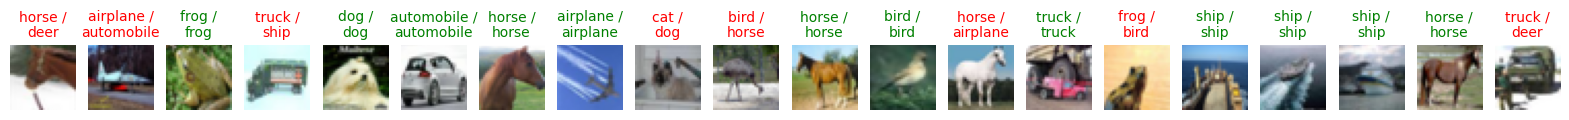

In [ ]:
def plot_predictions_vs_actual_labels(dataset, result_values):
  '''
  Given a dataset and an array of prediction results, plot the first 20 images
  in the data set labeled with actual and predicted classes.
  '''
  i = 0
  fig, ax = plt.subplots(1,20, figsize=(20,5))
  # retrieve the first batch in test_set
  for image, label in dataset.take(1):
    # iterate over the five first image in the first batch
    for j in range(0,20):
      # get integer value from predicted probability
      predicted_label = np.argmax(result_values[j])
      actual_label = np.argmax(label[j])
      ax[i].axis('off')
      # set image labels
      if names[actual_label] == names[predicted_label]:
        ax[i].set_title(names[actual_label] + " /\n" + names[predicted_label], fontsize=10, color="green")
      else:
        ax[i].set_title(names[actual_label] + " /\n" + names[predicted_label], fontsize=10, color="red")
      ax[i].set_title(names[actual_label] + " /\n" + names[predicted_label], fontsize=10)
      # show images
      ax[i].imshow(image[j])
      i += 1
  print("")
  print("Actual image label vs Predicted image label \n")

# predict classes
result = model.predict(test_set, batch_size=32)

# plot label comparison sample
plot_predictions_vs_actual_labels(test_set, result)

In this subset of 20 images, 11 were correctly predicted, 9 wrongly predicted.
